# Titanic Training Model

This is the part 2 of this exercise where I will create pipeline for data processing, using GridSearchCV or RandomSearchCV to search for the best hyperparameters for the model, generate predictions on the test dataset.

**Information from previous part**:
1. SVC model is best suited for this exercise.
2. Dataset with full features (Important + Unimportant) gives better CV results.
3. Dataset should be normalized by Standard Scaler.
4. NULL values in 'Age' should be replace by the mean age.

## Imports

In [91]:
from datetime import datetime
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import joblib
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay
from mltoolkit.preprocessing import MyScaler,ImputeFromOtherColumn,ExtractFromString,DropNAX,DropNAy
from mltoolkit.utils import dump_model
from mltoolkit.model_selection import measure_classifier,test_water

## Classes

In [2]:
class ImputeFromOtherColumn(BaseEstimator,TransformerMixin):
    def __init__(self,impute_on:str,on_col:str,strategy:str='mean'):
        '''
        Replace missing values using a descriptive statistic (e.g. mean, median)
        along the target column based on the category that this row instance
        falls on another column.
        
        This imputer accepts pandas.DataFrame only.
        
        Parameters:
        ----------
        impute_on: str
            The target column.
        on_col: str
            The categorical column where the imputer will read the category of 
            the missing value in this column and assign the descriptive 
            statistical value (e.g. mean, median) to replace the missing value.
        strategy: str | {'mean','median'}
        '''
        self.impute_on = impute_on
        self.on_col = on_col
        if strategy not in ['mean','median']:
            raise ValueError("Value entered not in accepted strategies: 'mean' or 'median'")
        self.strategy = strategy
        self.groupby_results = None
        return None
    def fit(self,X,y=None):
        if type(X) is not pd.DataFrame:
            raise ValueError("Please fit pandas.DataFrame only.")
        
        if self.strategy == 'mean':
            self.groupby_results = X.groupby(self.on_col).mean()[self.impute_on]
        elif self.strategy == 'median':
            self.groupby_results = X.groupby(self.on_col).median()[self.impute_on]
        return self
    def transform(self,X,y=None):
        if self.groupby_results is None:
            raise ValueError("Please fit this transformer with data before transforming.")
        if type(X) is not pd.DataFrame:
            raise ValueError("Please transform pandas.DataFrame only.")
        X_copy = X.copy()
        X_null = X_copy[X_copy[self.impute_on].isnull()]
        
        for ind in X_null.index.values:
            val_at_key = X_null.loc[ind,self.on_col]
            X_copy.loc[ind,self.impute_on] = self.groupby_results[val_at_key]
        return X_copy

In [3]:
class ExtractFromString(BaseEstimator,TransformerMixin):
    def __init__(self,pattern):
        self.pattern = pattern
        return None
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if type(X) is pd.DataFrame:
            X = X.iloc[:,0]
        elif type(X) is np.ndarray:
            X = pd.Series(X.flatten())
        else:
            raise ValueError("Only pd.DataFrame or np.ndarray are accepted for transformation")
        X = X.str.extract(self.pattern).values
        return X

In [4]:
class DropNAX(BaseEstimator,TransformerMixin):
    def __init__(self,subset=None,out_df=False,path="System\\"):
        '''
        Drop NA for specified columns.
        
        Parameters:
        ----------
        subset: int, str or list of int/str, Default None
            When 'subset' = None, it will drop NA where NA is found for all rows.
        out_df: bool, Default: False
            When out_df = True, the output is a pandas DataFrame, this enables
            this transformer to be used in chaining with ColumnTransformer.
        path: str, Default: "System\\"
            The path to save the indexer for y data indexing in the transformer
            'DropNAy'.
        '''
        self.subset = subset
        self.out_df = out_df
        self.path = path
        return None
    def fit(self,X,y=None,subset=None):
        if subset is not None:
            self.subset = subset
        return self
    def transform(self,X,y=None):
        if type(X) is np.ndarray:
            X = pd.DataFrame(X)
        X = X.dropna(subset=self.subset)
        
        try:
            os.mkdir(self.path)
        except:
            pass
        joblib.dump(X.index,self.path+"y_indexer",compress=3)
        
        if self.out_df: return X
        else: return X.values

In [5]:
class DropNAy(BaseEstimator,TransformerMixin):
    def __init__(self,out_sr=False,path="System\\"):
        '''
        Drop NA for y using the saved indexer from a previous Drop NA action
        on X by 'DropNAX'.
        
        Parameters:
        ----------
        out_sr: bool, Default: False
            When out_sr = True, the output is a pandas Series.
        path: str, Default: "System\\"
            The path to load the indexer saved by the transformer 'DropNAX'
            for y data indexing.
        '''
        self.out_sr = out_sr
        self.path = path
        self.indexer = None
        return None
    def fit(self,y):
        self.indexer = joblib.load(self.path+"y_indexer")
        return self
    def transform(self,y):
        if type(y) is np.ndarray:
            y = pd.Series(y)
        y = y[self.indexer]
        if self.out_sr: return y
        else: return y.values

## Functions

In [95]:
def dump_model(estimator,path = "Trained Models\\",filename=None,yhat=None,scores=None,compress=5):
    '''
    Dump the objects passed as arguments into .pkl file.
    '''
    try:
        os.mkdir(path)
    except:
        pass
    # Dump estimator
    if not filename: filename = str(estimator)[:str(estimator).find('(')]
    joblib.dump(estimator,path+filename+".pkl",compress=compress)
    # Dump yhat
    if yhat is not None:
        joblib.dump(yhat,path+filename+"_yhat"+".pkl",compress=compress)
    # Dump cv scores
    if scores is not None:
        joblib.dump(scores,path+filename+"_scores"+".pkl",compress=compress)

In [6]:
def measure_classifier(estimator,trainortest:str,y_true,y_pred) -> dict:
    '''
    Quickly measure the performance of an estimator using common scoring method
    for classification.
    
    Parameters:
    ----------
    estimator: Estimator object
        Mainly for the use of extracting the name and labeling the output dict.
    trainortest: str
        To label the results as train or test measurement.
    y_true: 1D-ndarray
        True labels.
    y_pred: 1D-ndarray
        Predicted labels.
    
    Returns:
    ----------
    dict: Dictionary
    '''
    acc = accuracy_score(y_true,y_pred)
    prec = precision_score(y_true,y_pred)
    rec = recall_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred)
    
    name = str(estimator)
    # [:str(estimator).find('(')]
    print("Estimator:",name)
    print("Train/Test:",trainortest.title())
    print("Accuracy:",acc)
    print("Precision:",prec)
    print("Recall:",rec)
    print("F1:",f1)
    f = plt.figure(figsize=(6,6))
    ax = f.gca()
    cmdisp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred,
                                                     display_labels=['Dead','Survived'],
                                                     cmap='Greys',ax=ax)
    plt.show()
    results = {
        "Estimator":name,
        "Train/Test":trainortest.title(),
        "Accuracy":acc,
        "Precision":prec,
        "Recall":rec,
        "F1":f1,
        "Confusion Matrix":cmdisp
    }
    return results

## Loading Datasets

In [2]:
loadingpath = "Datasets\\"
X_train_raw = joblib.load(loadingpath+"X_train_raw.pkl")
y_train_raw = joblib.load(loadingpath+"y_train_raw.pkl")
X_test_raw = joblib.load(loadingpath+"X_test_raw.pkl")

Making a copy of each datasets so that we don't accidentally mess with the raw datasets.

In [3]:
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()
X_test = X_test_raw.copy()

## Pipeline

In [4]:
float_caster = FunctionTransformer(lambda x:x.astype('float').values.reshape(-1,1) if (type(x) is pd.DataFrame or type(x) is pd.Series) else x.astype('float').reshape(-1,1))

In [5]:
process_ticket = Pipeline([
    ("ext_int",ExtractFromString(pattern="([0-9]+$)")),
    ("cast_float",float_caster),
    ("impute_age",SimpleImputer(strategy='mean'))
])

In [6]:
transformers = [
    # ("drop_col_a",'drop',['Name','Cabin']),
    ("impute_age",SimpleImputer(strategy='mean'),['Age']),
    ("process_ticket",process_ticket,['Ticket']),
    ("encode_sex",OrdinalEncoder(),['Sex']),
    ("encode_embarked",OneHotEncoder(sparse=False),['Embarked']),
    ("drop_col",'drop',['Name','Cabin','Embarked']),
]

In [7]:
transformer_pipe = Pipeline([
    ("impute_fare",ImputeFromOtherColumn('Fare','Pclass','mean')),
    ("drop_na",DropNAX(['Fare','Embarked'],out_df=True)),
    ("coltrans",ColumnTransformer(transformers,remainder='passthrough')),
    # ("drop_na",DropNA()),
    ("std_scale",MyScaler('std')),
])

In [8]:
transformer_pipe

Pipeline(steps=[('impute_fare',
                 ImputeFromOtherColumn(impute_on='Fare', on_col='Pclass')),
                ('drop_na', DropNAX(out_df=True, subset=['Fare', 'Embarked'])),
                ('coltrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_age', SimpleImputer(),
                                                  ['Age']),
                                                 ('process_ticket',
                                                  Pipeline(steps=[('ext_int',
                                                                   ExtractFromString(pattern='([0-9]+$)')),
                                                                  ('cast_float',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001CA992ECA60>)),
                                                                  ('impute_age',
                                                                   SimpleImputer())]),
                                                  ['Ticket']),
                                                 ('encode_sex',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('encode_embarked',
                                                  OneHotEncoder(sparse=False),
                                                  ['Embarked']),
                                                 ('drop_col', 'drop',
                                                  ['Name', 'Cabin',
                                                   'Embarked'])])),
                ('std_scale', MyScaler(scalertype='std'))])

In [9]:
today = datetime.today().date()
savingpath = "Datasets\\"
pd.DataFrame(X_train).to_csv(savingpath+f"X_train_{today}.csv",index=False)

Because we need to One Hot Encode the column 'Embarked', we need to first remove the NULL values from this column, so that the NULL value doesn't get categorized into another new category.

In [10]:
X_transpipe = transformer_pipe.fit_transform(X_train,y_train)
X_transpipe,X_transpipe.shape

(array([[-5.89619855e-01, -4.22845551e-01,  7.35342031e-01, ...,
          4.31350239e-01, -4.74325852e-01, -5.00239751e-01],
        [ 6.44847987e-01, -4.28286979e-01, -1.35991138e+00, ...,
          4.31350239e-01, -4.74325852e-01,  7.88946608e-01],
        [-2.81002895e-01,  4.26926104e+00, -1.35991138e+00, ...,
         -4.75199081e-01, -4.74325852e-01, -4.86649935e-01],
        ...,
        [ 7.94910081e-15, -4.45031712e-01, -1.35991138e+00, ...,
          4.31350239e-01,  2.00611934e+00, -1.74084157e-01],
        [-2.81002895e-01, -2.85441856e-01,  7.35342031e-01, ...,
         -4.75199081e-01, -4.74325852e-01, -4.22126048e-02],
        [ 1.81922546e-01,  1.09118097e-01,  7.35342031e-01, ...,
         -4.75199081e-01, -4.74325852e-01, -4.90173220e-01]]),
 (889, 10))

In [11]:
y_dropper = DropNAy()

In [12]:
y_transpipe = y_dropper.fit_transform(y_train)
y_transpipe

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

In [13]:
today = datetime.today().date()
savingpath = "Datasets\\"
pd.DataFrame(X_transpipe).to_csv(savingpath+f"X_transpipe_{today}.csv",index=False)
pd.Series(y_transpipe).to_csv(savingpath+f"y_transpipe_{today}.csv",index=False)

## SVM

In [126]:
svc_0 = SVC().fit(X_transpipe,y_transpipe)

In [139]:
svc_0_yhat_train = svc_0.predict(X_transpipe)
svc_0_yhat_train

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,

Estimator: SVC()
Train/Test: Train
Accuracy: 0.8470191226096738
Precision: 0.8923076923076924
Recall: 0.6823529411764706
F1: 0.7733333333333334


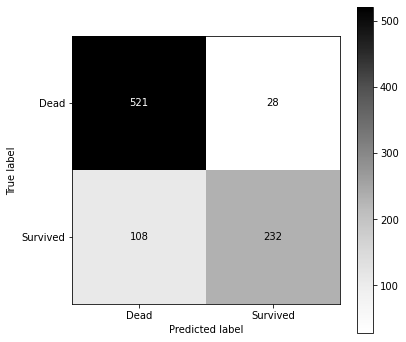

In [276]:
svc_0_results = measure_classifier(svc_0,"Train",y_transpipe,svc_0_yhat_train)

### Grid Search

In [282]:
param_grid = {
    "C":[0.01,0.1,10,100],
    "kernel":['linear', 'poly', 'rbf', 'sigmoid'],
    "class_weight":['balanced',None],
}

In [283]:
svc = SVC()
svc_gs = GridSearchCV(svc,param_grid,scoring='accuracy',n_jobs=4,cv=5)

In [284]:
svc_gs.fit(X_transpipe,y_transpipe)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 10, 100],
                         'class_weight': ['balanced', None],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [287]:
svc_gs_cv_results = pd.DataFrame(svc_gs.cv_results_)
svc_gs_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014801,2.787821e-03,0.003599,0.000489,0.01,balanced,linear,"{'C': 0.01, 'class_weight': 'balanced', 'kerne...",0.797753,0.803371,0.786517,0.752809,0.785311,0.785152,0.017542,14
1,0.026401,2.415503e-03,0.005801,0.000748,0.01,balanced,poly,"{'C': 0.01, 'class_weight': 'balanced', 'kerne...",0.629213,0.780899,0.674157,0.691011,0.717514,0.698559,0.050200,26
2,0.032604,5.462577e-03,0.019050,0.003151,0.01,balanced,rbf,"{'C': 0.01, 'class_weight': 'balanced', 'kerne...",0.691011,0.747191,0.747191,0.747191,0.734463,0.733410,0.021765,23
3,0.028431,3.729319e-03,0.009377,0.007656,0.01,balanced,sigmoid,"{'C': 0.01, 'class_weight': 'balanced', 'kerne...",0.685393,0.792135,0.808989,0.752809,0.807910,0.769447,0.046689,21
4,0.015630,8.176054e-07,0.000000,0.000000,0.01,None,linear,"{'C': 0.01, 'class_weight': None, 'kernel': 'l...",0.803371,0.803371,0.786517,0.752809,0.785311,0.786276,0.018469,10
5,0.009377,7.656680e-03,0.012504,0.006252,0.01,None,poly,"{'C': 0.01, 'class_weight': None, 'kernel': 'p...",0.634831,0.640449,0.623596,0.629213,0.632768,0.632172,0.005626,30
6,0.018755,6.251431e-03,0.014953,0.008855,0.01,None,rbf,"{'C': 0.01, 'class_weight': None, 'kernel': 'r...",0.617978,0.617978,0.617978,0.617978,0.615819,0.617546,0.000863,32
7,0.019719,6.161328e-03,0.007318,0.008636,0.01,None,sigmoid,"{'C': 0.01, 'class_weight': None, 'kernel': 's...",0.629213,0.617978,0.617978,0.617978,0.615819,0.619793,0.004784,31
8,0.007323,6.462870e-03,0.007303,0.006971,0.1,balanced,linear,"{'C': 0.1, 'class_weight': 'balanced', 'kernel...",0.797753,0.814607,0.786517,0.752809,0.785311,0.787399,0.020244,6
9,0.017935,7.078049e-03,0.000000,0.000000,0.1,balanced,poly,"{'C': 0.1, 'class_weight': 'balanced', 'kernel...",0.752809,0.797753,0.758427,0.713483,0.762712,0.757037,0.026858,22


In [288]:
svc_gs.best_params_

{'C': 10, 'class_weight': None, 'kernel': 'rbf'}

In [289]:
svc_gs.best_score_

0.8110582111343871

From the Grid Search, it shows that the model trained with the best parameters has around 81% CV test accuracy.

We will use there hyperparameters as our final options and train a model on these parameters on with the full training dataset.

In [99]:
svc_1 = SVC(C=10).fit(X_transpipe,y_transpipe)

In [100]:
svc_1_yhat_train = svc_1.predict(X_transpipe)

Estimator: SVC(C=10)
Train/Test: Train
Accuracy: 0.8571428571428571
Precision: 0.9018867924528302
Recall: 0.7029411764705882
F1: 0.7900826446280992


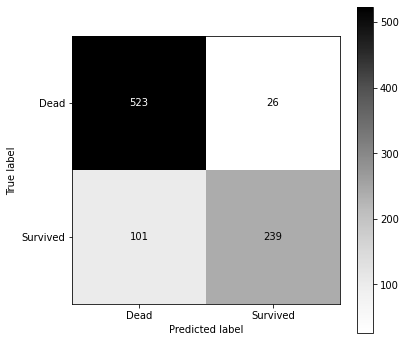

In [101]:
svc_1_results = measure_classifier(svc_1,"Train",y_transpipe,svc_1_yhat_train)

In [ ]:
X_transpipe_test = transformer_pipe.fit_transform(X_test)
X_transpipe_test,X_transpipe_test.shape

(array([[ 3.34992599e-01,  1.32042189e-01,  7.55928946e-01, ...,
         -4.99470017e-01, -4.00247702e-01, -4.97310928e-01],
        [ 1.32553003e+00,  1.87173173e-01, -1.32287566e+00, ...,
          6.16992373e-01, -4.00247702e-01, -5.12175100e-01],
        [ 2.51417495e+00, -2.23657945e-02,  7.55928946e-01, ...,
         -4.99470017e-01, -4.00247702e-01, -4.63999195e-01],
        ...,
        [ 6.51964577e-01,  4.85167933e+00,  7.55928946e-01, ...,
         -4.99470017e-01, -4.00247702e-01, -5.07693620e-01],
        [-2.53374904e-15,  1.80421710e-01,  7.55928946e-01, ...,
         -4.99470017e-01, -4.00247702e-01, -4.93352886e-01],
        [-2.53374904e-15, -4.27160545e-01,  7.55928946e-01, ...,
          6.16992373e-01,  6.19895831e-01, -2.36863471e-01]]),
 (418, 10))

In [ ]:
pd.DataFrame(X_transpipe_test).to_csv("Datasets\\X_transpipe_test.csv",index=False)

In [102]:
svc_1_yhat_test = svc_1.predict(X_transpipe_test)

In [103]:
pd.DataFrame(svc_1_yhat_test).to_csv("Datasets\\svc_1_yhat_test.csv",header=False,index=False)

### Saving the model

In [105]:
svc_1_yhats = {
    "svc_1_yhat_train":svc_1_yhat_train,
    "svc_1_yhat_test":svc_1_yhat_test,
}

In [106]:
dump_model(svc_1,yhat=svc_1_yhats,scores=svc_1_results)

## Random Forest Classifier

We will now simply test one more model that we left out previously on EDA stage, which is the Random Forest Classifier.

In [16]:
rforest_test_water_results = test_water([RandomForestClassifier],X_transpipe,y_transpipe,cv=5,n_jobs=4,return_train_score=True)
rforest_test_water_results

,run,estimator,fit_time,score_time,test_score,train_score
0,0,RandomForestClassifier,0.211018,0.019000,0.803371,0.998594
1,1,RandomForestClassifier,0.196016,0.012001,0.780899,0.998594
2,2,RandomForestClassifier,0.214015,0.011005,0.842697,0.997187
3,3,RandomForestClassifier,0.225016,0.019004,0.820225,1.000000
4,4,RandomForestClassifier,0.164010,0.011000,0.853107,1.000000


In [24]:
rforest_test_water_results[['test_score','train_score']].mean()

test_score     0.820060
train_score    0.998875
dtype: float64

We can see that a Random Forest Classifier performs slightly better than the best grid search CV results for that of SVM model.\
So its worth for us to further tune the hyperparameters to see how even better Random Forest Classifier can perform.\
We can also notice that the Random Forest Classifier is currently overfitting to the training data.

As such, we will try to regularize the model to make it less complex.

### Grid Search

In [30]:
param_grid = [
    {"criterion":["gini", "entropy"]},
    {"max_depth":[5,10,15,20,25,50,100]},
    {"min_samples_split":[2,3,5,10,15]},
    {"max_leaf_nodes":[20,40,60,80,100]},
]

In [31]:
rforest = RandomForestClassifier()
rforest_gs0 = GridSearchCV(rforest,param_grid,cv=5,n_jobs=4,scoring='accuracy',return_train_score=True)

In [32]:
rforest_gs0.fit(X_transpipe,y_transpipe)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid=[{'criterion': ['gini', 'entropy']},
                         {'max_depth': [5, 10, 15, 20, 25, 50, 100]},
                         {'min_samples_split': [2, 3, 5, 10, 15]},
                         {'max_leaf_nodes': [20, 40, 60, 80, 100]}],
             return_train_score=True, scoring='accuracy')

In [34]:
rforest_gs0_cv_results = pd.DataFrame(rforest_gs0.cv_results_)

In [42]:
rforest_gs0_cv_results.iloc[:,[4,5,6,7,8,9,10,11,12,13,14,16,-2]]

,param_criterion,param_max_depth,param_min_samples_split,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,rank_test_score,mean_train_score
0,gini,NaN,NaN,NaN,{'criterion': 'gini'},0.825843,0.825843,0.853933,0.831461,0.847458,0.836907,9,0.999156
1,entropy,NaN,NaN,NaN,{'criterion': 'entropy'},0.820225,0.820225,0.848315,0.825843,0.830508,0.829023,18,0.998875
2,NaN,5,NaN,NaN,{'max_depth': 5},0.803371,0.837079,0.848315,0.792135,0.841808,0.824541,19,0.867270
3,NaN,10,NaN,NaN,{'max_depth': 10},0.803371,0.831461,0.853933,0.831461,0.864407,0.836926,8,0.962317
4,NaN,15,NaN,NaN,{'max_depth': 15},0.814607,0.820225,0.848315,0.808989,0.870056,0.832438,13,0.997188
5,NaN,20,NaN,NaN,{'max_depth': 20},0.797753,0.808989,0.853933,0.825843,0.858757,0.829055,16,0.999156
6,NaN,25,NaN,NaN,{'max_depth': 25},0.820225,0.808989,0.859551,0.831461,0.853107,0.834666,11,0.999156
7,NaN,50,NaN,NaN,{'max_depth': 50},0.814607,0.825843,0.853933,0.831461,0.864407,0.838050,5,0.998594
8,NaN,100,NaN,NaN,{'max_depth': 100},0.825843,0.825843,0.865169,0.825843,0.841808,0.836901,10,0.999156
9,NaN,NaN,2,NaN,{'min_samples_split': 2},0.825843,0.820225,0.870787,0.831461,0.853107,0.840284,3,0.999156


In [97]:
rforest_gs0_cv_results.to_csv("Trained Models\\rforest_gs0_cv_results.csv")

In [44]:
rforest_gs1_param_grid = {
    "criterion":["gini"],
    "max_depth":[10,15,20,30,40,50],
    "min_samples_split":[3,5,7],
    "max_leaf_nodes":[40,60,80,100]
}


In [49]:
rforest = RandomForestClassifier()
rforest_gs1 = GridSearchCV(rforest,rforest_gs1_param_grid,cv=5,n_jobs=4,scoring='accuracy',return_train_score=True)

In [50]:
rforest_gs1.fit(X_transpipe,y_transpipe)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini'],
                         'max_depth': [10, 15, 20, 30, 40, 50],
                         'max_leaf_nodes': [40, 60, 80, 100],
                         'min_samples_split': [3, 5, 7]},
             return_train_score=True, scoring='accuracy')

In [51]:
rforest_gs1_cv_results = pd.DataFrame(rforest_gs1.cv_results_)

In [53]:
rforest_gs1_cv_results.to_csv("Trained Models\\rforest_gs1_cv_results.csv")

In [54]:
rforest_gs1.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_leaf_nodes': 80,
 'min_samples_split': 3}

In [56]:
rforest_gs1.best_score_

0.8492858503142259

From the Grid Search, it shows that the model trained with the best parameters has around 85% CV test accuracy.

We will use there hyperparameters as our final options and train a model on these parameters on with the full training dataset.\
Hopefully that works well

In [59]:
rforest_1 = RandomForestClassifier(criterion='gini',max_depth=15,max_leaf_nodes=80,min_samples_split=3)

In [60]:
rforest_1.fit(X_transpipe,y_transpipe)

RandomForestClassifier(max_depth=15, max_leaf_nodes=80, min_samples_split=3)

In [61]:
rforest_1_yhat_train = rforest_1.predict(X_transpipe)

Estimator: RandomForestClassifier(max_depth=15, max_leaf_nodes=80, min_samples_split=3)
Train/Test: Train
Accuracy: 0.9358830146231721
Precision: 0.9609120521172638
Recall: 0.8676470588235294
F1: 0.9119010819165378


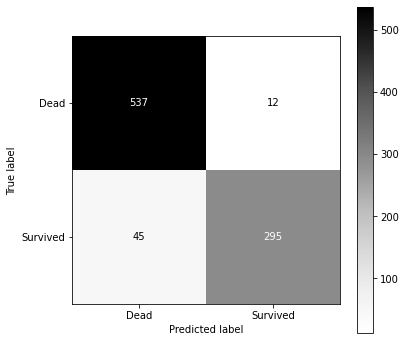

In [63]:
rforest_1_results = measure_classifier(rforest_1,"Train",y_transpipe,rforest_1_yhat_train)

Looks like we have a satisfied training results.\
Unfortunately, we dont have a y test dataset.

We will generate predictions based on the X test dataset.

In [66]:
rforest_1_yhat_test = rforest_1.predict(X_transpipe_test)

In [75]:
pd.DataFrame(rforest_1_yhat_test).to_csv("Datasets\\rforest_1_yhat_test.csv",header=False,index=False)

### Saving the model

In [76]:
rforest_1_yhats = {
    "rforest_1_yhat_train":rforest_1_yhat_train,
    "rforest_1_yhat_test":rforest_1_yhat_test,
}

In [96]:
dump_model(rforest_1,yhat=rforest_1_yhats,scores=rforest_1_results)